# Taxi Duration Prediction
- Dataset: [TLC Trip Record Data
](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [1]:
!python -V

Python 3.11.3


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
df = pd.read_parquet('../data/yellow_tripdata_2022-01.parquet')

In [7]:
ori_size = df.shape[0]

In [8]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [10]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df['duration'].dt.total_seconds() / 60

In [11]:
df['duration'].describe()

count    2.463931e+06
mean     1.421220e+01
std      4.644531e+01
min     -3.442400e+03
25%      6.316667e+00
50%      1.018333e+01
75%      1.616667e+01
max      8.513183e+03
Name: duration, dtype: float64

In [12]:
# outlier removal: keep only the records where the duration was between 1 and 60 minutes (inclusive)
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [13]:
post_removal_size = df.shape[0]
(post_removal_size/ori_size)*100 # Fraction of the records left after you dropped the outliers

98.27547930522405

In [14]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df.loc[:, categorical] = df[categorical].astype(str)

In [15]:
train_dicts = df[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.001496179445599

In [16]:
X_train.shape

(2421440, 516)

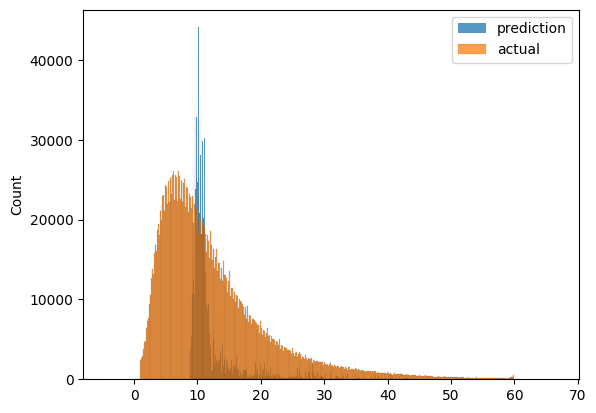

In [17]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()
plt.show()

In [18]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['duration'] = df['duration'].dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df.loc[:,categorical] = df[categorical].astype(str)
    
    return df

In [19]:
df_train = read_dataframe('../data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('../data/yellow_tripdata_2022-02.parquet')

In [20]:
len(df_train), len(df_val)

(2421440, 2918187)

In [21]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [22]:
categorical =  ['PULocationID', 'DOLocationID'] #['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

# train_dicts = df_train[categorical + numerical].to_dict(orient='records')
train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [23]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

7.786408015215065

In [27]:
# RMSE on train
y_pred = lr.predict(X_train)
print(mean_squared_error(y_train, y_pred, squared=False))
# RMSE on val
y_pred = lr.predict(X_val)
print(mean_squared_error(y_val, y_pred, squared=False))

6.986191065500608
7.786408015215065


In [25]:
# with open('models/lin_reg.bin', 'wb') as f_out:
#     pickle.dump((dv, lr), f_out)

In [26]:
# lr = Lasso(0.01)
# lr.fit(X_train, y_train)

# y_pred = lr.predict(X_val)

# mean_squared_error(y_val, y_pred, squared=False)